In [1]:
#Libraries
using Gen
using PyPlot
using Plots
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using StatsBase;

In [2]:
#To-Do: December 23rd, 2020
#Modify across proposals (nodes first, do layers second)
#Draw the new network completely from the prior
#In the birth case, draw the new network and follow it with HMC steps
#In the death case, first do an HMC step and then draw a new network of decreased size from the prior
#Refer to page 6 of Sen and Biswas (2017), equations 27, 28, 29
#MAKE SURE ALL THE PROBABILITIES ARE CALCULATED CORRECTLY
#This SHOULD fix the problem of collapsing to a single node

In [3]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
#network = "classifier"
network = "interpolator"

#Data hyperparameters
n = 5000 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 20 #Input dimension
N = n*4 #Total samples
σₐ = 0.1 #Mode variance (classifier)
bound = 1.0 #Axis bound

#Network hyperparameters
α = 0.2 #Gamma Scale for Hyperparameters
ωᵧ = 100 #Gamma Mean for Noise
αᵧ = 0.2 #Gamma Scale for Noise
σₖ = 1.0

#Node hyperparameters
k_range = 12 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]
l_range = 5 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 3
k_real = [5,8,3]
k = k_real;

#Helper Functions
function plot_data(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha)
    PyPlot.colorbar()
end

function plot_surf(data,scores)
    PyPlot.scatter(data[:,1],data[:,2],data[:,3],c=scores)
end

function plot_contour(data, scores, alpha=1.0)
    PyPlot.contour(data[:,1],data[:,2],c=scores)
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

function layer_unpacker(i,l,k)
    if i == 1
        input_dim = d
        output_dim = k[i]
    else
        input_dim = k[i-1]
        output_dim = k[i]
    end
    return input_dim, output_dim
end;

In [91]:
#-------------------------------
#Generative Interpolator Network
#-------------------------------

#Bayesian Neural Net
function G(x, trace)
    activation = sigmoid
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)],1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

#Create a Random Network
@gen function generator()

    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = 1
    
    ω₁ = 1
    ω₂ = sum([obs[(:k,i)] for i=1:l]) #Neal (1996): Scaling relationship to # of hidden units
    τ₁ ~ gamma(ω₁,α) #Hidden Weights
    τ₂ ~ gamma(ω₁,α) #Hidden Biases
    τ₃ ~ gamma(ω₂,α) #Output Weights
    τᵧ ~ gamma(ωᵧ,α) #Noise Parameter for y
    #τ₄ ~ gamma() #Output Biases - Neal uses fixed sigmas here
    
    #Standard Deviations
    σ₁ = sqrt(1/τ₁)
    σ₂ = sqrt(1/τ₂)
    σ₃ = sqrt(1/τ₃)
    σᵧ = sqrt(1/τᵧ)
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            μ = zeros(h)
            Σ = Diagonal([σ₁ for i=1:length(μ)])
            W[i] = @trace(mvnormal(μ,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            μ2 = ones(k[i])
            Σ2 = Diagonal([σ₂ for i=1:length(μ2)])
            b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            μₒ = zeros(k[l])
            Σₒ = Diagonal([σ₃ for i=1:length(μₒ)])
            W[i] = @trace(mvnormal(μₒ,Σₒ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            μ2ₒ = ones(1)
            Σ2ₒ = Diagonal([1.0 for i=1:length(μ2ₒ)])
            b[i] = @trace(mvnormal(μ2ₒ,Σ2ₒ), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
end;

In [92]:
#Test out Generator function so far
obs = choicemap()::ChoiceMap

(trace,) = generate(generator, (), obs);
#println(trace[:l])
#println([trace[(:k,i)] for i=1:trace[:l]])
#println([trace[(:W,i)] for i=1:trace[:l]])
#println([trace[(:b,i)] for i=1:trace[:l]])

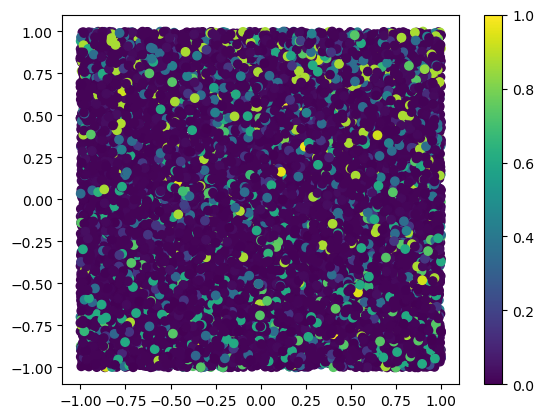

PyObject <matplotlib.colorbar.Colorbar object at 0x7f2780f95490>

In [93]:
#---------------------------------------------------
#Generate Network Parameters and Corresponding Curve
#---------------------------------------------------
obs = choicemap()::ChoiceMap
obs[:l] = 5
#obs[(:k,1)] = 200
x_raw = rand(Uniform(-bound,bound),(N,d))
x = transpose(x_raw)
data = x
data_raw = x_raw

(trace,) = generate(generator, (), obs)

y_real = G(x.*10,trace)[1,:]
y_real = [y_real[i] + normal(0.0,0.001) for i=1:length(y_real)]


dt = StatsBase.fit(UnitRangeTransform, y_real, dims=1, unit=true)
y_real = StatsBase.transform(dt, y_real)
#plot_surf(x_raw,y_real)
plot_data(x_raw,y_real)
#display(x_raw)
#display(y_real)

In [79]:
function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-bound,bound)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = G(grid2,trace)[1,:]
plot_data(grid_raw, z);

DimensionMismatch: DimensionMismatch("A has dimensions (10,20) but B has dimensions (2,10000)")

In [94]:
#Classifier Network Tries to Learn the Generator Network

@gen function classifier(x::Array{Float64})
    #Prepare ChoiceMap to send through to BNN (G)
    obs = choicemap()::ChoiceMap

    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = 1
    
    #Hyperparameters for weights and biases
    ω₁ = 1
    ω₂ = sum([obs[(:k,i)] for i=1:l]) #Neal (1996): Scaling relationship to # of hidden units
    ωᵧ = 100 #Gamma Mean for Noise
    αᵧ = 0.2
    
    τ₁ ~ gamma(ω₁,α) #Hidden Weights
    τ₂ ~ gamma(ω₁,α) #Hidden Biases
    τ₃ ~ gamma(ω₂,α) #Output Weights
    τᵧ ~ gamma(ωᵧ,αᵧ) #Noise Parameter for y
    #τ₄ ~ gamma() #Output Biases - Neal uses fixed sigmas here
    
    #Standard Deviations
    σ₁ = sqrt(1/τ₁)
    σ₂ = sqrt(1/τ₂)
    σ₃ = sqrt(1/τ₃)
    σᵧ = sqrt(1/τᵧ)
    #println(σ₃)
    #println(σᵧ)
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end
        
        if i<=l
            #Hidden Weights
            μ = zeros(h)
            Σ = Diagonal([σ₁ for i=1:length(μ)])
            W[i] = @trace(mvnormal(μ,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            μ2 = ones(k[i])
            Σ2 = Diagonal([σ₂ for i=1:length(μ2)])
            b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            μₒ = zeros(k[l])
            Σₒ = Diagonal([σ₃ for i=1:length(μₒ)])
            W[i] = @trace(mvnormal(μₒ,Σₒ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            μ2ₒ = ones(1)
            Σ2ₒ = Diagonal([1.0 for i=1:length(μ2ₒ)])
            b[i] = @trace(mvnormal(μ2ₒ,Σ2ₒ), (:b,i))
            obs[(:b,i)] = b[i]
        end
            
    end
    
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))
    
    return y
end;

classifier(x);

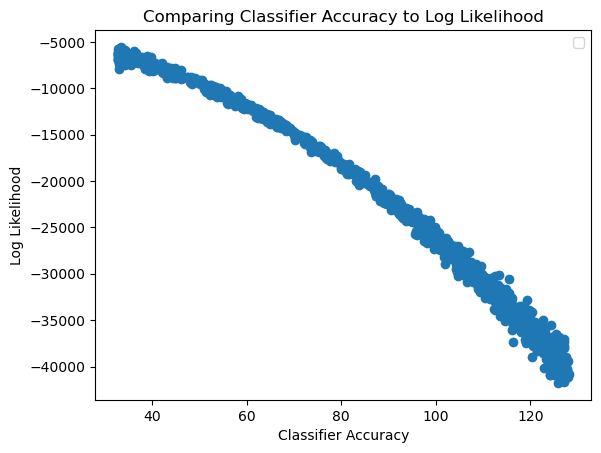

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f27810e3d50>

In [95]:
#-----------------------------------------
#Register Observed Data - Test Likelihood
#-----------------------------------------

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master;
#obs[:l] = 5

scores = []
distances = []
ls = []
best_ls = []
best_traces = []
(best_trace,) = generate(classifier, (x,), obs)
best_score = get_score(best_trace)
best_l = best_trace[:l]

best_pred_y = Flux.σ.(G(x,best_trace))
best_dist = euclidean(best_pred_y, y_real)

function likelihood(best_trace, best_dist, best_score, best_l)
    obs = obs_master;
    (trace,) = generate(classifier, (x,), obs)
    pred_y = Flux.σ.(G(x,trace))

    dist = euclidean(pred_y, y_real)
    score = get_score(trace)
    #println(score)
    if dist < best_dist
        best_dist = dist
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_l = best_trace[:l]
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(distances,dist)
    #push!(ls, l)
    #println(best_score)
    return(best_trace, best_dist, best_score, best_l)
end;

for i=1:1000
    best_trace, best_dist, best_score, best_l = likelihood(best_trace, best_dist, best_score, best_l)
    push!(best_ls, best_l)
end

PyPlot.scatter(distances, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
#plt.ylim(-5000,2000)
plt.legend()

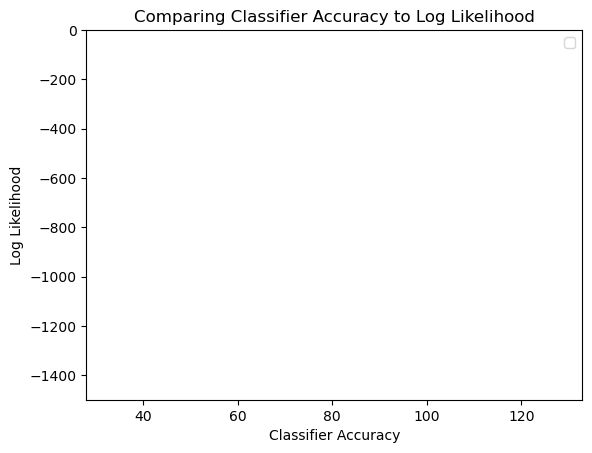

4
1


No handles with labels found to put in legend.


In [96]:
PyPlot.scatter(distances, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.ylim(-1500,0)
plt.legend()
println(best_trace[:l])
println(best_trace[(:k,1)])

In [97]:
#-------------------------
#Layer Birth / Death Moves
#-------------------------

function obs_maker(trace)
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_real
    obs_new[:l] = trace[:l]
    obs_new[:τ₁] = trace[:τ₁]
    obs_new[:τ₂] = trace[:τ₂]
    obs_new[:τ₃] = trace[:τ₃]
    obs_new[:τᵧ] = trace[:τᵧ]
    return obs_new
end

function layer_change(trace)
    current_l = trace[:l]
    if current_l == last(l_list)
        new_trace = layer_death(trace)
    elseif current_l == l_list[1]
        new_trace = layer_birth(trace)
    else
        new_trace = bernoulli(0.5) ? layer_birth(trace) : layer_death(trace)
    end
    return new_trace    
end

@gen function layer_birth(trace)
    
    previous_l = trace[:l]
    new_l = l_list[previous_l + 1]
    difference = abs(new_l - previous_l)
    
    #Where to insert new layer
    insert = rand((1:new_l))
    
    obs_new = obs_maker(trace)
    obs_new[:l] = new_l
    
    for i=1:new_l+1
        if i == insert
            obs_new[(:k,i)] = 1
        elseif i < insert
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i-1)]
        end
    end
    
    (new_trace, weight) = generate(classifier, (x,), obs_new)
    return new_trace
    
end

@gen function layer_death(trace)
    
    previous_l = trace[:l]
    new_l = l_list[previous_l - 1]
    difference = abs(new_l - previous_l)
    
    #Where to insert new layer
    delete = rand((1:previous_l))
    
    obs_new = obs_maker(trace)
    obs_new[:l] = new_l
    
    for i=1:new_l+1
        if i < delete
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i+1)]
        end
    end
    
    (new_trace, weight) = generate(classifier, (x,), obs_new)
    return new_trace
    
end;

function node_change(trace)
    current_l = trace[:l]
    layer = rand((1:current_l))
    #println("Proposed layer: $layer")
    current_k = trace[(:k, layer)]
    if current_k == last(k_list)
        new_trace = node_death(trace,layer)
    elseif current_k == k_list[1]
        new_trace = node_birth(trace,layer)
    else
        new_trace = bernoulli(0.5) ? node_birth(trace,layer) : node_death(trace,layer)
    end
    return new_trace        
end

@gen function node_birth(trace, layer)
    
    previous_k = trace[(:k,layer)]
    new_k = k_list[previous_k + 1]
    difference = abs(new_k - previous_k)
    
    #Select Insertion Place for New Neuron
    insert = rand((1:new_k))
    
    #Create new choicemap and fill with real Y values
    obs_new = obs_maker(trace)
    obs_new[:l] = trace[:l]
    
    #Fill k values in new ChoiceMap
    for i=1:trace[:l]+1
        if i == layer
            obs_new[(:k,i)] = new_k
        elseif i < layer
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i)]
        end
    end
    
    #Get the input and output dimensions of the edit layer
    in_dim, out_dim = layer_unpacker(layer,trace[:l],[obs_new[(:k,i)] for i=1:obs_new[:l]])
    output = trace[:l] + 1
    
    #Hyperparameters for new proposals
    σ₁ = sqrt(1/obs_new[:τ₁])
    σ₂ = sqrt(1/obs_new[:τ₂])
    σ₃ = sqrt(1/obs_new[:τ₃])
    
    for i=1:trace[:l]
        if i == layer
            obs_new[(:k,i)] = new_k
            W1 = [trace[(:W,i)][j] for j=1:length(trace[(:W,i)])]
            b1 = [trace[(:b,i)][j] for j=1:length(trace[(:b,i)])]
            for j=1:in_dim
                W1 = insert!(W1,insert+((j-1)*(out_dim)),normal(0,σ₁))
            end
            obs_new[(:W,i)] = W1
            obs_new[(:b,i)] = insert!(b1, insert, normal(1,σ₂))
            
            if layer == trace[:l]
                W2 = [trace[(:W,output)][j] for j=1:length(trace[(:W,output)])]
                obs_new[(:W,output)] = insert!(W2,insert,normal(0,σ₃))
                obs_new[(:b,output)] = trace[(:b,output)]
            else
                new_dim = obs_new[(:k,i+1)]
                W2 = [trace[(:W,i+1)][j] for j=1:length(trace[(:W,i+1)])]
                b2 = [trace[(:b,i+1)][j] for j=1:length(trace[(:b,i+1)])]
                for j=1:new_dim
                    W2 = insert!(W2,new_dim*(insert-1)+1,normal(0,σ₁))
                end
                obs_new[(:W,i+1)] = W2
                obs_new[(:b,i+1)] = b2
                obs_new[(:W,output)] = trace[(:W,output)]
                obs_new[(:b,output)] = trace[(:b,output)]
            end
            
        elseif i == layer + 1
            continue
        elseif i < layer
            obs_new[(:W,i)] = trace[(:W,i)]
            obs_new[(:b,i)] = trace[(:b,i)]
        else
            obs_new[(:W,i)] = trace[(:W,i)]
            obs_new[(:b,i)] = trace[(:b,i)]
        end
    end
    
    (new_trace, weight) = generate(classifier, (x,), obs_new)
    return new_trace
end

@gen function node_death(trace, layer)
    
    previous_k = trace[(:k,layer)]
    new_k = k_list[previous_k - 1]
    difference = abs(new_k - previous_k)
    
    #Select Insertion Place for New Neuron
    delete = rand((1:previous_k))
    #delete=5
    
    #Create new choicemap and fill with real Y values
    obs_new = obs_maker(trace)
    obs_new[:l] = trace[:l]
    
    #Fill k values in new ChoiceMap
    for i=1:trace[:l]+1
        if i == layer
            obs_new[(:k,i)] = new_k
        elseif i < layer
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i)]
        end
    end
    
    #Get the input and output dimensions of the edit layer
    in_dim, out_dim = layer_unpacker(layer,trace[:l],[obs_new[(:k,i)] for i=1:obs_new[:l]])
    output = trace[:l] + 1
    
    for i=1:trace[:l]
        if i == layer
            obs_new[(:k,i)] = new_k
            W1 = [trace[(:W,i)][j] for j=1:length(trace[(:W,i)])]
            b1 = [trace[(:b,i)][j] for j=1:length(trace[(:b,i)])]
            for j=1:in_dim
                W1 = deleteat!(W1,delete+((j-1)*(out_dim)))
            end
            obs_new[(:W,i)] = W1
            obs_new[(:b,i)] = deleteat!(b1, delete)
            
            if layer == trace[:l]
                W2 = [trace[(:W,output)][j] for j=1:length(trace[(:W,output)])]
                obs_new[(:W,output)] = deleteat!(W2,delete)
                obs_new[(:b,output)] = trace[(:b,output)]
            else
                new_dim = obs_new[(:k,i+1)]
                W2 = [trace[(:W,i+1)][j] for j=1:length(trace[(:W,i+1)])]
                b2 = [trace[(:b,i+1)][j] for j=1:length(trace[(:b,i+1)])]
                for j=1:new_dim
                    W2 = deleteat!(W2,new_dim*(delete-1)+1)
                end
                obs_new[(:W,i+1)] = W2
                obs_new[(:b,i+1)] = b2
                obs_new[(:W,output)] = trace[(:W,output)]
                obs_new[(:b,output)] = trace[(:b,output)]
            end
            
        elseif i == layer + 1
            continue
        elseif i < layer
            obs_new[(:W,i)] = trace[(:W,i)]
            obs_new[(:b,i)] = trace[(:b,i)]
        else
            obs_new[(:W,i)] = trace[(:W,i)]
            obs_new[(:b,i)] = trace[(:b,i)]
        end
    end
    
    (new_trace, weight) = generate(classifier, (x,), obs_new)
    return new_trace
    
end;

In [99]:
obs = obs_master
obs[:l] = 3
hz = 3
(trace,) = generate(classifier, (x,), obs)
trace2 = node_death(trace,hz)
println(trace[(:k,hz)])
println(trace2[(:k,hz)])

8
7


In [101]:
#-------------------------
#RJMCMC - Layers and Nodes
#-------------------------

traces = []
acc = []
acc_a = []
acc_w = []
acc_l = []
ls = []
epss = []

function select_hyperparameters(trace, obs)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    (new_trace,weight,retdiff) = regenerate(trace, args, argdiffs, select(:τ₁,:τ₂,:τ₃,:τᵧ))
    obs[:τ₁] = new_trace[:τ₁]
    obs[:τ₂] = new_trace[:τ₂]
    obs[:τ₃] = new_trace[:τ₃]
    obs[:τᵧ] = new_trace[:τᵧ]
    return new_trace, obs
end

function select_selection(trace)
    l = trace[:l]
    selection = select()
    for i=1:l+1
        push!(selection, (:W,i))
        push!(selection, (:b,i))
    end
    return selection
end

function within_move(trace, iters, obs)
    for i=1:iters
        eps = uniform(0.01,0.02)
        selection = select_selection(trace)
        (trace, accepted) = hmc(trace, selection, L=10, eps=eps, check=false, observations=obs)
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
        #accepted && println("Within accepted")
    end
    return trace
end

function node_move(trace, iters, obs)
    
    #Determine birth or death
    current_l = trace[:l]
    layer = rand((1:current_l))
    current_k = trace[(:k, layer)]
    
    if current_k == last(k_list)
        move_type = 0
    elseif current_k == k_list[1]
        move_type = 1
    else
        move_type = bernoulli(0.5)
    end
    move = "Empty"
    
    if move_type == 1
        #For birth move, first propose birth, then HMC
        move = "Birth"
        new_trace = node_birth(trace, layer)
        score_test = get_score(new_trace)
        selection = select_selection(trace)
        test = true
        for i=1:iters
            eps = uniform(0.2,0.5)
            (new_trace, accepted) = hmc(new_trace, selection, L=10, eps=eps, check=false, observations=obs)
            accepted && push!(epss, eps)
            #accepted && (test = false)
        end
    else
        #For death move, HMC steps come first (Sen and Biswas, 2017)
        move = "Death"
        new_trace = trace
        selection = select_selection(new_trace)
        for i=1:iters
            new_trace = trace
            eps = uniform(0.01,0.6)
            (new_trace, accepted) = hmc(new_trace, selection, L=10, eps=eps, check=false, observations=obs)
            #accepted && (test = false)
        end
        score_test = get_score(new_trace)
        new_trace = node_death(new_trace, layer)
        test = true
    end
    
    #OLD SCHEME - OUTDATED
    #---------------------------
    #new_trace = node_change(trace)
    #score_test = get_score(new_trace)
    #selection = select_selection(trace)
    
    #test = true
    #for i=1:iters
        #eps = uniform(0.5,0.6)
        #(new_trace, accepted) = hmc(new_trace, selection, L=1, eps=eps, check=false, observations=obs)
        #accepted && (test = false)
    #end
    #test && println("Nothing accepted")
    #----------------------------------
    
    score1 = get_score(trace)
    score2 = get_score(new_trace)
    
    logscore = (score2 - score1)
    score = exp(logscore)

    println("$move Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = [trace[(:k,i)] for i=1:trace[:l]]
        #println("New ks accepted! Current ks: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
    
    #obs = obs_master
    #for i=1:trace[:l]
        #obs[(:k,i)] = trace[(:k,i)]
    #end
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return trace
end

function layer_move(trace, iters, obs)
    
    new_trace = layer_change(trace)
    score_test = get_score(new_trace)
    selection = select_selection(old_selection)
    
    test = true
    for i=1:iters
        eps = uniform(0.0015,0.01)
        (new_trace, accepted) = hmc(new_trace, selection, L=10, eps=eps, check=false, observations=obs)
        #accepted && (test = false)
    end
    #test && println("Nothing accepted")
    
    score1 = get_score(trace)
    score2 = get_score(new_trace)
    
    logscore = (score2 - score1)
    score = exp(logscore)

    println("Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:l]
        #println("New l accepted! Current l: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
    
    obs = obs_master
    obs[:l] = trace[:l]
    for i=1:trace[:l]
        obs[(:k,i)] = trace[(:k,i)]
    end
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_l, accepted)
    return trace , obs[:l]
    
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:trace[:l]]
    println("Beginning RJMCMC. Starting l: $l")
    println("Starting ks: $ks")
    println("--------------------------------")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        l = trace[:l]
        ks = [trace[(:k,i)] for i=1:trace[:l]]
        #x_samp, y_samp = sample_data(x, y_real)
        #x_samp = transpose(x_samp)
        obs_master = choicemap()::ChoiceMap
        obs_master[:y] = y_real
        obs = obs_master;
        if i%10 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            #println("Epoch $i layer count: $l, ks: $ks")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            println("Epoch $i Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
            #println("Epoch $i Layer Acceptance Prob: $(sum(acc_l)/length(acc_l))")
            println([trace[(:k,i)] for i=1:trace[:l]])
        end
        
        #Gibbs sampling for hyperparameters
        trace, obs = select_hyperparameters(trace, obs)
        
        #Indicator variable for move type
        u = rand(Uniform(0,1))
        if u > 1.00
            (trace, l) = layer_move(trace, 30, obs)
        elseif u > 0.0
            (trace) = node_move(trace, 1, obs)
        else
            (trace) = within_move(trace, 1, obs)
        end
        push!(ls, l)
    end
    println("Finished")
end
 
runs = 3
#starting_trace = best_trace

#x_samp, y_samp = sample_data(x, y_real)
#x_samp = transpose(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs_master[:l] = 1
obs = obs_master
(starting_trace,) = generate(classifier, (x,), obs)
#starting_trace = best_trace
obs[:l] = starting_trace[:l]

rjmcmc(starting_trace,runs);

Beginning RJMCMC. Starting l: 1
Starting ks: [3]
--------------------------------


InterruptException: InterruptException:

In [88]:
print(epss)

Any[0.23299494815949842, 0.47513750552587786, 0.574048405477592, 0.02933940345905281, 0.33862651931450477, 0.46410993857724375]

In [267]:
obs = choicemap()::ChoiceMap
(trace,) = generate(classifier, (x,), obs)
args = get_args(trace)
argdiffs = map((_) -> NoChange(), args)
(trace2,weight,retdiff) = regenerate(trace, args, argdiffs, select(:τ₁,:τ₂,:τ₃,:τᵧ))

println(trace[:l])
println(trace2[:l])
println(trace[:τ₁])
println(trace2[:τ₁])

4
4
0.018894282665106912
0.13193829084755812


In [ ]:
obs = choicemap()::ChoiceMap
obs[:l] = 3
(trace,) = generate(classifier, (x,), obs)
args = get_args(trace)
argdiffs = map((_) -> NoChange(), args)
selection = select((:W,1))
push!(selection, (:W,2))
push!(selection, (:Wₒ))
(trace2,weight,retdiff) = regenerate(trace, args, argdiffs, selection)
println(trace[(:W,1)])
println(trace2[(:W,1)])
println(trace[(:W,2)])
println(trace2[(:W,2)])
println(trace[(:W,3)])
println(trace2[(:W,3)])

In [ ]:
println(selection)
selection2 = select_selection(trace)
println(selection2)

In [ ]:
(new_trace, accepted) = hmc(trace, selection, L=10, eps=0.01, check=false, observations=obs)

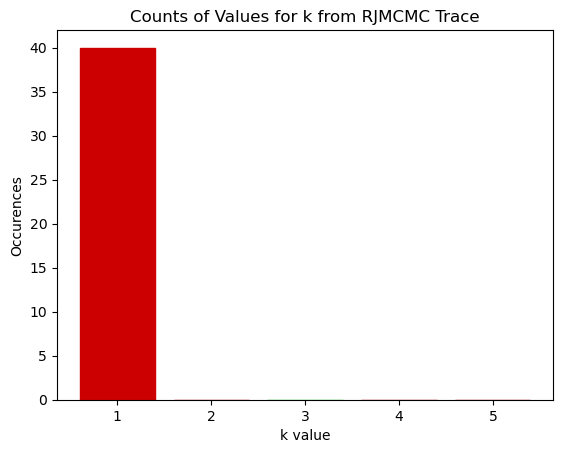

In [27]:
#Bar Plot of k estimates
counts = [sum([ls[i] == j for i in 1:length(ls)]) for j in l_list]
barlist=PyPlot.bar(l_list,counts)
for i in 1:l_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[l_real].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

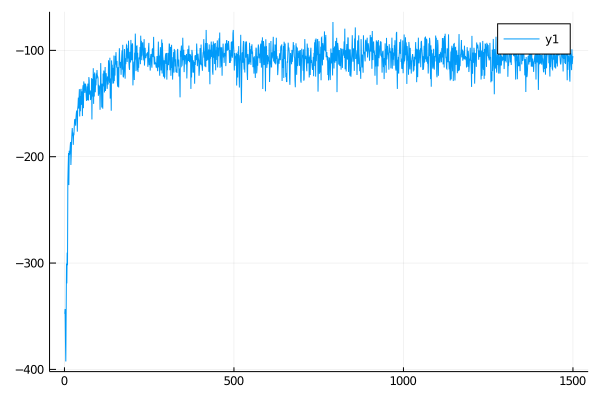

In [52]:
#Scores Plot
scores = [get_score(traces[i]) for i=1:length(traces)]
Plots.plot(scores[1:length(scores)])

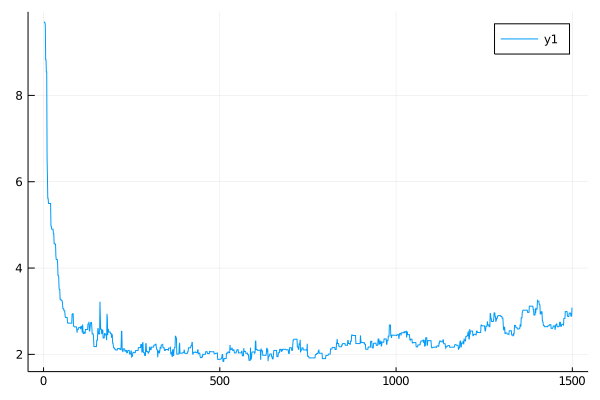

In [53]:
#Distances Plot
distances_trace = []
for i=1:length(traces)
    current_trace = traces[i]
    current_pred_y = Flux.σ.(G(x,current_trace))
    dist = euclidean(current_pred_y, y_real)
    push!(distances_trace,dist)
end
Plots.plot(distances_trace)

In [ ]:
#Best Guess
best_i = 1
for i=1:length(traces)
    test_trace = traces[i]
    test_score = get_score(test_trace)
    if test_score > get_score(traces[best_i]) 
        best_i = i
        println(test_score)
    end
    #println("Epoch $i Score: $test_score")
end

print(best_i)
best_trace = traces[best_i];

function tracegrid(trace, low=-bound, high=bound)
    d=2
    n=100
    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z = Flux.σ.(G(grid2,trace))[1,:]
    plot_data(grid_raw, z)
end

tracegrid(traces[best_i])

In [ ]:
function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-bound,bound)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = G(grid2,trace)[1,:]
plot_data(grid_raw, z);

In [ ]:
best_i = 1
for i=1:length(traces)
    test_trace = traces[i]
    test_score = get_score(test_trace)
    if test_score > get_score(traces[best_i]) 
        best_i = i
        #print(test_score)
    end
    #println("Epoch $i Score: $test_score")
end

Q = 1000
y_prime = zeros(length(y_real))

for j=1:Q
    rand_i = rand((1:length(traces)))
    trace_now = traces[rand_i]

    y_test = Flux.σ.(G(x,trace_now)[1,:])
    y_prime += y_test .* (1/Q)
    #println(euclidean(y_test, y_real))
end

plot_data(x_raw,y_prime)

In [ ]:
obs = choicemap()::ChoiceMap
obs[:y] = y_real
(trace1, weight) = generate(classifier, (x,), obs)
println(trace1[:l])
println([trace1[(:k,i)] for i=1:trace1[:l]])

In [ ]:
obs_test = node_death(trace1,2)
#for i = 1:obs_test[:l]
    #k_value = obs_test[(:k,i)]
    #println("New K value: $k_value")
    #println("Old Layer $i")
    #println(length(trace1[(:W,i)]))
    #println(length(trace1[(:b,i)]))
    #println("New Layer $i")
    #println(length(obs_test[(:W,i)]))
    #println(length(obs_test[(:b,i)]))
#end

#println("Old Layer1")
#println(trace1[(:W,1)])
#println("New Layer1")
#println(obs_test[(:W,1)])

println("Old Layer2")
println(trace1[(:W,2)])
println("New Layer2")
println(obs_test[(:W,2)])

println("Old Output")
println(trace1[:Wₒ])
println("New Output")
println(obs_test[:Wₒ])
#println(obs_test[:l])
#println([trace2[(:k,i)] for i=1:trace2[:l]])
#println(trace1[(:W,2)])
#println(trace2[(:W,2)])

In [ ]:
in_dim, out_dim = layer_unpacker(2, trace1[:l], [trace1[(:k,i)] for i=1:trace1[:l]])
W = reshape(trace1[(:W,2)], out_dim, in_dim)
display(W)
#b = reshape(trace[(:b,i)], trace[(:k,i)])

in_dim2, out_dim2 = layer_unpacker(2, obs_test[:l], [obs_test[(:k,i)] for i=1:obs_test[:l]])
W2 = reshape(obs_test[(:W,2)], out_dim2, in_dim2)
display(W2)

In [ ]:
in_dim, out_dim = layer_unpacker(3, trace2[:l], [trace2[(:k,i)] for i=1:trace2[:l]])
println(trace2[(:W,3)])
W = reshape(trace2[(:W,3)], out_dim, in_dim)

In [ ]:
obs = choicemap()::ChoiceMap
obs[:y] = y_real
(trace1, weight) = generate(classifier, (x,), obs)
println(trace1[:l])
println([trace1[(:k,i)] for i=1:trace1[:l]])

if trace1[:l] != 5
    trace2 = layer_birth(trace1)
    println(trace2[:l])
    println([trace2[(:k,i)] for i=1:trace2[:l]])
end

In [ ]:
obs = choicemap()::ChoiceMap
obs[:y] = y_real
(trace1, weight) = generate(classifier, (x,), obs)
println(trace1[:l])
println([trace1[(:k,i)] for i=1:trace1[:l]])

if trace1[:l] != 1
    trace2 = layer_death(trace1)
    println(trace2[:l])
    println([trace2[(:k,i)] for i=1:trace2[:l]])
end

In [ ]:
a = [1, 2, 3, 4, 5]
insert!(a, 1, 6)
insert!(a, 1, 7)

In [ ]:
    #Fill k values in new ChoiceMap
    for i=1:new_l
        if i == layer
            obs_new[(:k,i)] = new_k
            W1 = [trace[(:W,i)][j] for j=1:length(trace[(:W,i)])]
            b1 = [trace[(:b,i)][j] for j=1:length(trace[(:b,i)])]
            for j=1:
                obs_new[(:W,i)] = insert!
            end
            obs_new[(:b,i)] = insert!(b1, insert, normal(1,σₖ))
            if layer == last(l_list)
                W2 = [trace[:Wₒ][j] for j=1:length(trace[:Wₒ])]
                b2 = [trace[:bₒ][j] for j=1:length(trace[:bₒ])]
            else
                W2 = [trace[(:W,i)][j] for j=1:length(trace[(:W,i)])]
                b2 = [trace[(:b,i)][j] for j=1:length(trace[(:b,i)])]
            end
                
                
            

        elseif i < insert
            obs_new[(:k,i)] = trace[(:k,i)]
        else
            obs_new[(:k,i)] = trace[(:k,i-1)]
        end
    end
    
    #Adjust parameter vectors
    #obs_new[:Wₕ] = vcat(Wₕ,[normal(0,σₖ) for i=1:(2*difference)])
    #Wₕ = insert!(Wₕ, insert*2-1, normal(0,σₖ))
    #obs_new[:Wₕ] = insert!(Wₕ, insert*2, normal(0,σₖ))
    #obs_new[:Wₒ] = insert!(Wₒ, insert, normal(0,σₖ))
    #obs_new[:bₕ] = insert!(bₕ, insert, normal(1,σₖ))
    #obs_new[:bₒ] = bₒ

    #bs_new[:Wₕ] = vcat(Wₕ,[normal(0,σₖ) for i=1:(2*difference)])
    #obs_new[:Wₒ] = vcat(Wₒ,[normal(0,σₖ) for i=1:difference])
    #obs_new[:bₕ] = vcat(bₕ,[normal(1,σₖ) for i=1:difference])
    #obs_new[:bₒ] = bₒ
    #obs_new[:k] = new_k
    
    #(new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    #return new_trace